- [x] source RGB image를 기반으로 text caption을 generate하기
    - 선결 조건 dataframe이 잘 정의 되어 있고 여기에 write를 할 예정이다. 

compatibility issues, CUDA upper 12.0, torch below 2.3.0

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
from transformers import AutoTokenizer, AutoModel
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
import pandas as pd

import numpy as np


In [4]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio


def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [5]:
model_name = "OpenGVLab/InternVL3-14B"
local_path = "/workspace/weight/InternVL3-14B"

tokenizer = AutoTokenizer.from_pretrained(local_path, trust_remote_code=True, use_fast=False)

model = AutoModel.from_pretrained(
    local_path,
    torch_dtype=torch.bfloat16,
    load_in_8bit=True,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
# single-image single-round conversation (单图单轮对话)

example_image_dir = "/workspace/weight/InternVL3-14B/examples"
example_idx = "image1.jpg"

pixel_values = load_image(os.path.join(example_image_dir, example_idx), max_num=12).to(torch.bfloat16).cuda()
question = '<image>\nPlease describe the image shortly.'
generation_config = dict(max_new_tokens=1024, do_sample=True)

# response = model.chat(tokenizer, pixel_values, question, generation_config)
response = model.batch_chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

TypeError: 'NoneType' object is not iterable

In [17]:
len(responses)

1

In [12]:
# batch inference, single image per sample (单图批处理)
pixel_values = load_image(os.path.join(example_image_dir, example_idx), max_num=12).to(torch.bfloat16).cuda()
num_patches_list = [pixel_values.size(0), pixel_values.size(0), pixel_values.size(0), pixel_values.size(0)]
# pixel_values = torch.cat((pixel_values, pixel_values, pixel_values, pixel_values), dim=0)

multiplicate_factor = 16
num_patches_list = [pixel_values.size(0)] * multiplicate_factor
pixel_values = pixel_values.repeat(multiplicate_factor, 1, 1, 1)
questions = ['<image>\nDescribe the image in detail.'] * len(num_patches_list)

responses = model.batch_chat(tokenizer, pixel_values,
                             num_patches_list=num_patches_list,
                             questions=questions,
                             generation_config=generation_config)
for question, response in zip(questions, responses):
    print(f'User: {question}\nAssistant: {response}')

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.39 GiB. GPU 

In [1]:
df = pd.read_csv(os.path.join("./data", "3ddst.csv"))

NameError: name 'pd' is not defined

In [48]:
# dataframe sharding
# make caption perpose dataframe, done
num_shards = 8
# prof_df = df[df["dataset_type"].isin(["image_render" ,"caption"])]
prof_df = df[df["dataset_type"].isin(["image_render"])]
prof_df.loc[:,"caption"] = ""
sharded_proc_df = np.array_split(prof_df, num_shards)

/tmp/ipykernel_82803/1255021290.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prof_df.loc[:,"caption"] = ""
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
for start_idx in tqdm(range(0, len(df), batch_size)):
    end_idx = min(start_idx + batch_size, len(df))
    batch_df = df.iloc[start_idx:end_idx]
    
    # 배치 내 이미지 경로 생성
    image_paths = [
        os.path.join(top_dir, row['meta_class'], row['class'], row['dataset_type'], row['value'])
        for _, row in batch_df.iterrows()
    ]
    
    try:
        # 이미지 로드 및 픽셀 값 준비
        pixel_values_list = [load_image(path, max_num=12).to(torch.bfloat16).cuda() for path in image_paths]
        num_patches_list = [pv.size(0) for pv in pixel_values_list]  # 각 이미지의 패치 수
        pixel_values = torch.cat(pixel_values_list, dim=0)  # 배치 텐서로 결합
        
        # LLM에 보낼 질문 준비
        questions = ['<image>\nDescribe the image in detail.'] * len(image_paths)
        
        # 캡션 생성
        responses = model.batch_chat(
            tokenizer,
            pixel_values,
            num_patches_list=num_patches_list,
            questions=questions,
            generation_config=generation_config
        )
        
        # DataFrame에 캡션 업데이트
        df.loc[batch_df.index, 'caption'] = responses
    except Exception as e:
        print(f"배치 {start_idx // batch_size} 처리 중 오류 발생: {e}")
        # 오류 발생 시 캡션을 'Error'로 설정 (선택 사항)
        df.loc[batch_df.index, 'caption'] = 'Error'

In [49]:
prof_df

,meta_class,class,dataset_type,value,caption
27,n02988304,dcb921b4517a45db8853bfdd4d0cafdc,image_render,000.png,
28,n02988304,dcb921b4517a45db8853bfdd4d0cafdc,image_render,001.png,
29,n02988304,dcb921b4517a45db8853bfdd4d0cafdc,image_render,002.png,
30,n02988304,dcb921b4517a45db8853bfdd4d0cafdc,image_render,003.png,
31,n02988304,dcb921b4517a45db8853bfdd4d0cafdc,image_render,004.png,
...,...,...,...,...,...
231531,n02441942,96f9026ddace492b8a3945c1f7c7d35d,image_render,010.png,
231532,n02441942,96f9026ddace492b8a3945c1f7c7d35d,image_render,011.png,
231533,n02441942,96f9026ddace492b8a3945c1f7c7d35d,image_render,012.png,
231534,n02441942,96f9026ddace492b8a3945c1f7c7d35d,image_render,013.png,


In [42]:
# 16개씩 batchify하면서 LLM에 먹여주고 다시 받아서 dataframe에 기입하는 방식으로 하면 될듯하다.
sharded_proc_df[0].iloc[0]  # 이것을 index로서 사용하고 새로운 caption이라는 column을 만드는 방식으로 처리를 해야겠다.

meta_class                             n02988304
class           dcb921b4517a45db8853bfdd4d0cafdc
dataset_type                        image_render
value                                    000.png
Name: 27, dtype: object

In [27]:
sharded_df[-1]

,meta_class,class,dataset_type,value
202608,n02797295,40026615816b4a5bb97f760acfe85f25,annotation,003.npy
202609,n02797295,40026615816b4a5bb97f760acfe85f25,annotation,004.npy
202610,n02797295,40026615816b4a5bb97f760acfe85f25,annotation,005.npy
202611,n02797295,40026615816b4a5bb97f760acfe85f25,annotation,006.npy
202612,n02797295,40026615816b4a5bb97f760acfe85f25,annotation,007.npy
...,...,...,...,...
231547,n02441942,96f9026ddace492b8a3945c1f7c7d35d,normal_render,011.png
231548,n02441942,96f9026ddace492b8a3945c1f7c7d35d,normal_render,012.png
231549,n02441942,96f9026ddace492b8a3945c1f7c7d35d,normal_render,013.png
231550,n02441942,96f9026ddace492b8a3945c1f7c7d35d,normal_render,014.png


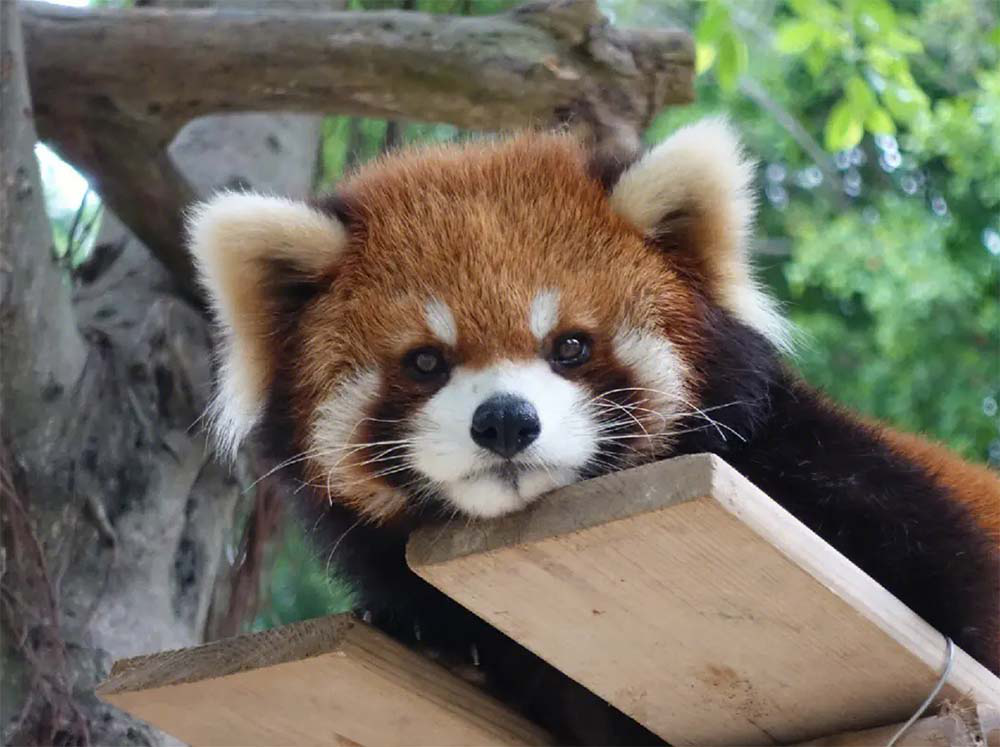

In [ ]:
example_image_dir = "/workspace/weight/InternVL3-14B/examples"
example_idx = "image1.jpg"
Image.open(os.path.join(example_image_dir, example_idx)).show()
# Assistant: The image features a red panda peeking out from behind a wooden structure, with its distinctive reddish-brown fur and round face visible. The background includes green foliage.

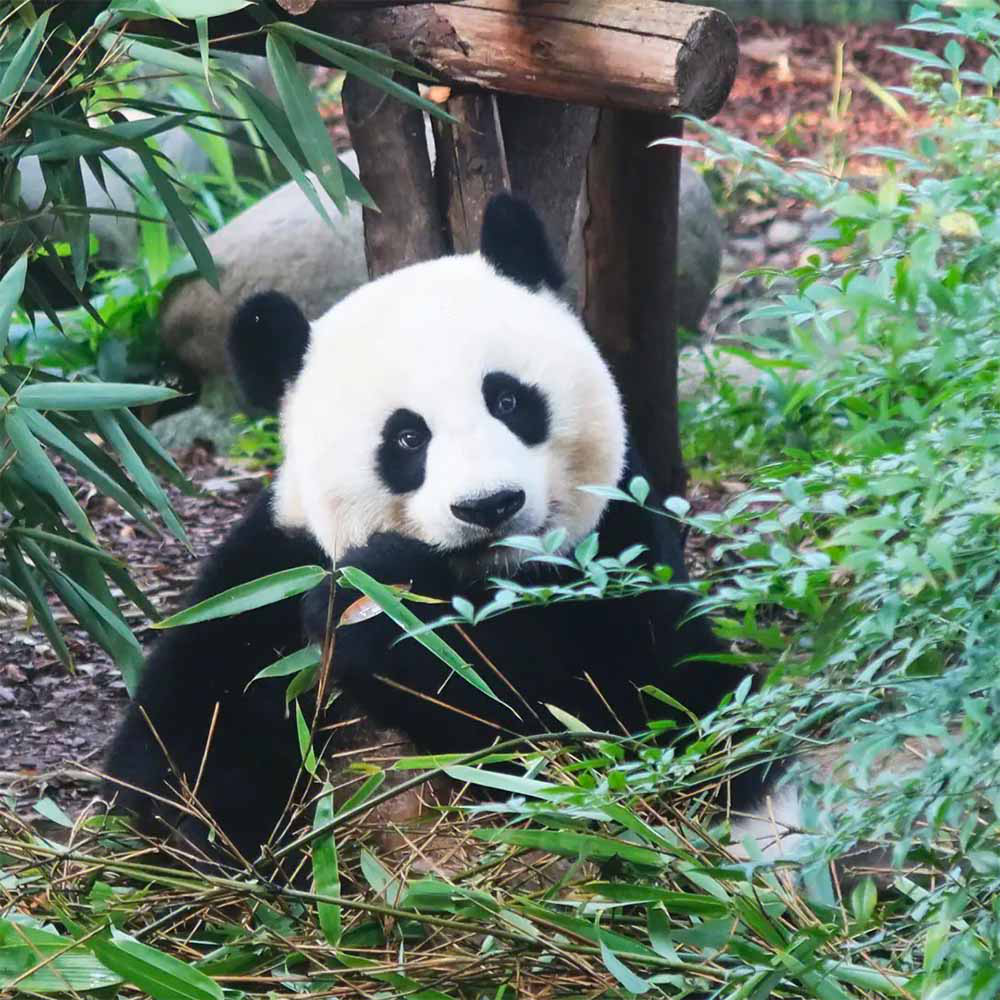

In [ ]:
example_image_dir = "/workspace/weight/InternVL3-14B/examples"
example_idx = "image2.jpg"
Image.open(os.path.join(example_image_dir, example_idx)).show()
# Assistant: A panda is sitting amidst bamboo, eating the leaves with a wooden structure in the background.
